In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score
import joblib

loading datasets

In [3]:
train = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [4]:

# Load and prepare data
train = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

# Process datetime
train['last contact date'] = pd.to_datetime(train['last contact date'])
train['year'] = train['last contact date'].dt.year
train['month'] = train['last contact date'].dt.month
train['weekday'] = train['last contact date'].dt.weekday
train.drop(columns=['last contact date'], inplace=True)


Conducting EDA on datasets for thorough understanding

In [5]:
print("\nDataset Info:")
train.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        39211 non-null  int64 
 1   job        38982 non-null  object
 2   marital    39211 non-null  object
 3   education  37744 non-null  object
 4   default    39211 non-null  object
 5   balance    39211 non-null  int64 
 6   housing    39211 non-null  object
 7   loan       39211 non-null  object
 8   contact    28875 non-null  object
 9   duration   39211 non-null  int64 
 10  campaign   39211 non-null  int64 
 11  pdays      39211 non-null  int64 
 12  previous   39211 non-null  int64 
 13  poutcome   9760 non-null   object
 14  target     39211 non-null  object
 15  year       39211 non-null  int32 
 16  month      39211 non-null  int32 
 17  weekday    39211 non-null  int32 
dtypes: int32(3), int64(6), object(9)
memory usage: 4.9+ MB


In [6]:
print("\nDataset Description:")
print(train.describe())



Dataset Description:
                age        balance      duration      campaign         pdays  \
count  39211.000000   39211.000000  39211.000000  39211.000000  39211.000000   
mean      42.120247    5441.781719    439.062789      5.108770     72.256051   
std       12.709352   16365.292065    769.096291      9.890153    160.942593   
min       18.000000   -8019.000000      0.000000      1.000000     -1.000000   
25%       33.000000      98.000000    109.000000      1.000000     -1.000000   
50%       40.000000     549.000000    197.000000      2.000000     -1.000000   
75%       50.000000    2030.000000    380.000000      4.000000     -1.000000   
max       95.000000  102127.000000   4918.000000     63.000000    871.000000   

           previous          year         month       weekday  
count  39211.000000  39211.000000  39211.000000  39211.000000  
mean      11.826171   2009.000791      6.223993      2.822575  
std       44.140259      0.818415      2.614273      1.741966  
m

In [7]:
#missing values
print("\nMissing Values:")
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values:
job            229
education     1467
contact      10336
poutcome     29451
dtype: int64


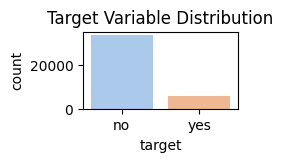

In [8]:
# Target distribution
plt.figure(figsize=(2,1))
sns.countplot(data=train, x='target', palette='pastel')
plt.title('Target Variable Distribution')
plt.show()

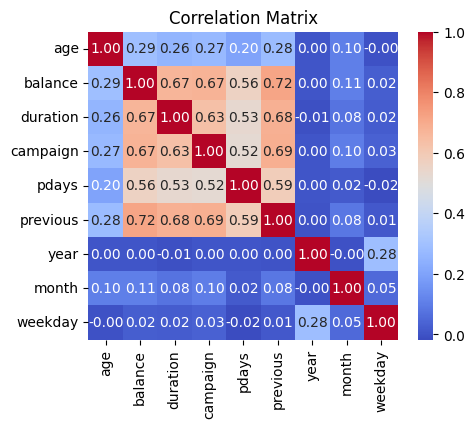

In [9]:
#correlation matrix
corr_matrix = train.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


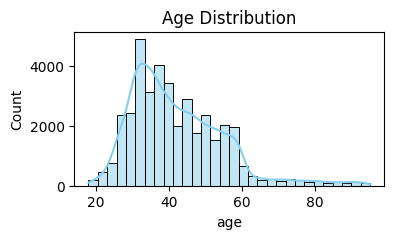

In [10]:
# Age distribution
plt.figure(figsize=(4, 2))
sns.histplot(train['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.show()


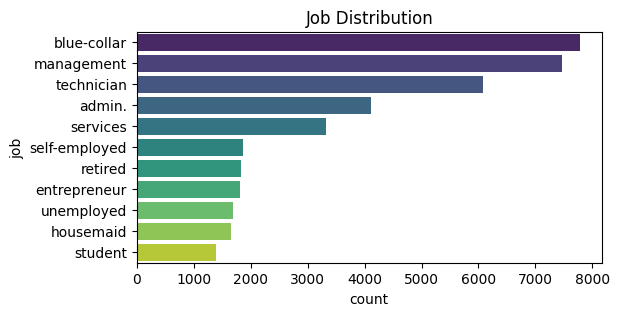

In [11]:
# Job distribution
plt.figure(figsize=(6, 3))
sns.countplot(data=train, y='job', order=train['job'].value_counts().index, palette='viridis')
plt.title('Job Distribution')
plt.show()

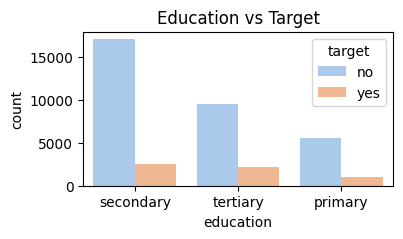

In [12]:
# Education and target relationship
plt.figure(figsize=(4, 2))
sns.countplot(data=train, x='education', hue='target', palette='pastel')
plt.title('Education vs Target')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


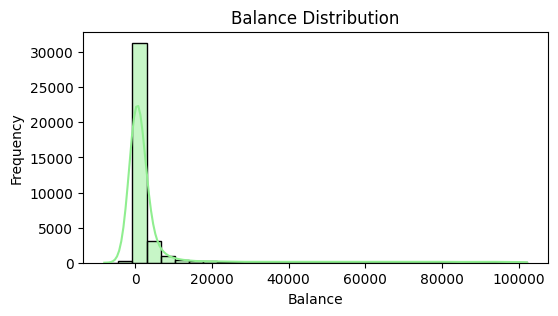

In [13]:
# Balance distribution
plt.figure(figsize=(6, 3))
sns.histplot(train['balance'], bins=30, kde=True, color='lightgreen')
plt.title("Balance Distribution")
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.show()

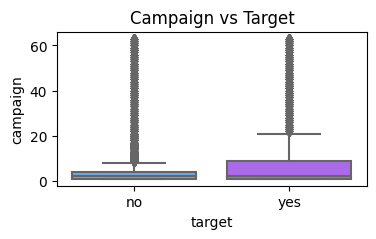

In [14]:
# Campaign feature vs target
plt.figure(figsize=(4, 2))
sns.boxplot(data=train, x='target', y='campaign', palette='cool')
plt.title('Campaign vs Target')
plt.show()

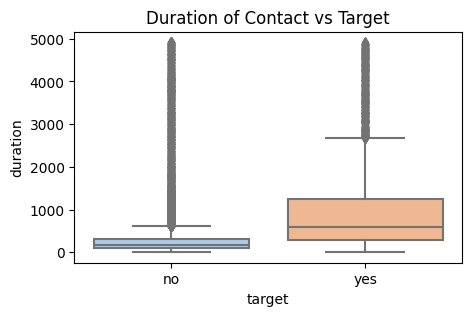

In [15]:
# Duration vs Target
plt.figure(figsize=(5, 3))
sns.boxplot(data=train, x='target', y='duration', palette='pastel')
plt.title('Duration of Contact vs Target')
plt.show()


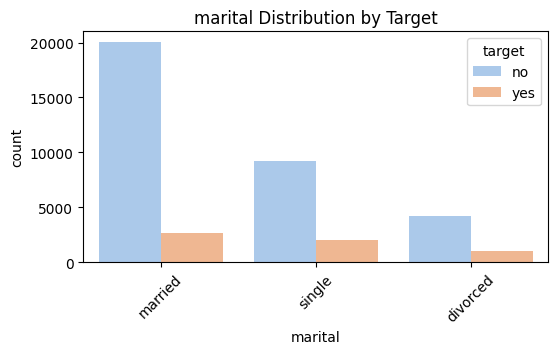

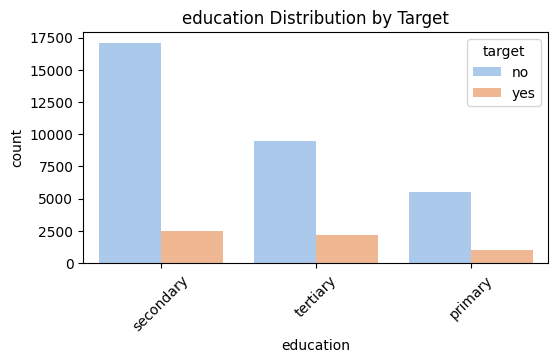

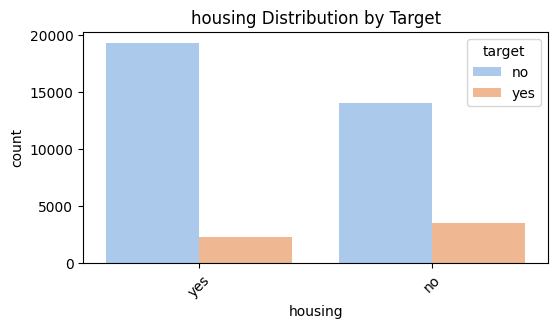

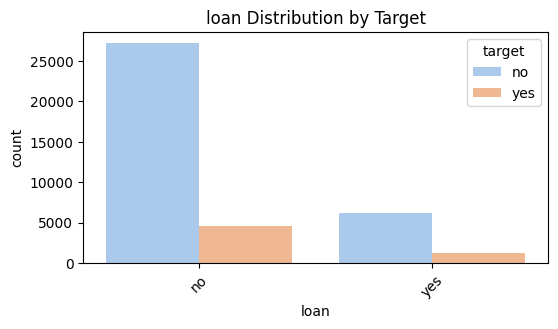

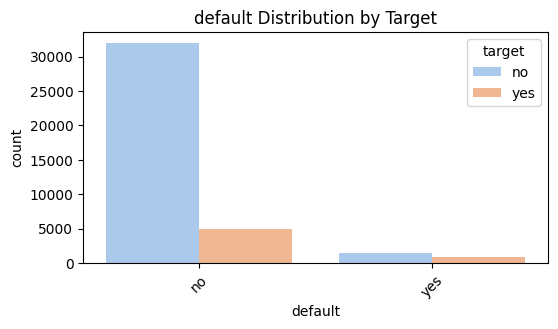

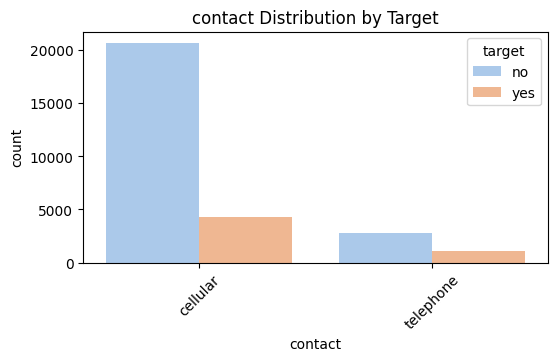

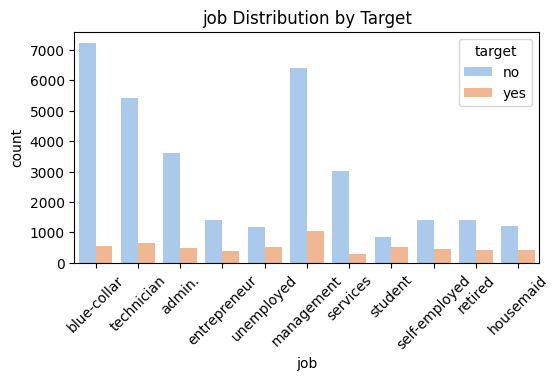

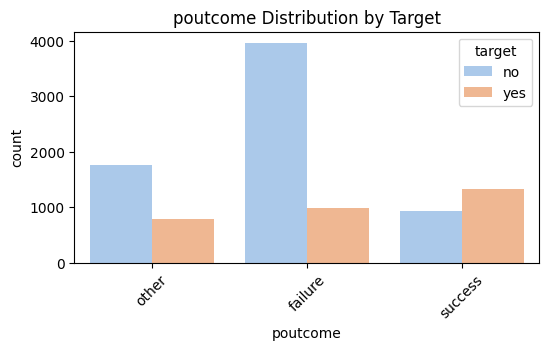

In [16]:
#categorical features
categorical_cols = ['marital', 'education', 'housing', 'loan', 'default', 'contact', 'job', 'poutcome']
for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=train, x=col, hue='target', palette='pastel')
    plt.title(f"{col} Distribution by Target")
    plt.xticks(rotation=45)
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


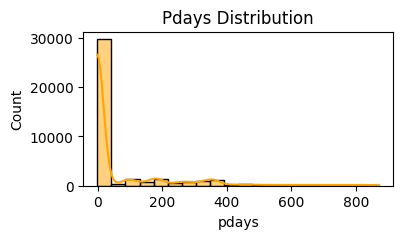

In [17]:
# Analyzing pdays
plt.figure(figsize=(4, 2))
sns.histplot(train['pdays'], bins=20, kde=True, color='orange')
plt.title('Pdays Distribution')
plt.show()

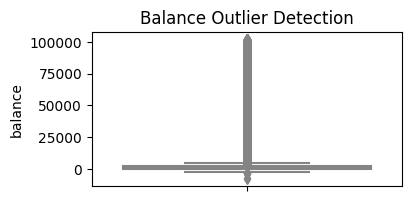

In [18]:
# Outlier detection in balance
plt.figure(figsize=(4, 2))
sns.boxplot(data=train, y='balance', palette='coolwarm')
plt.title('Balance Outlier Detection')
plt.show()

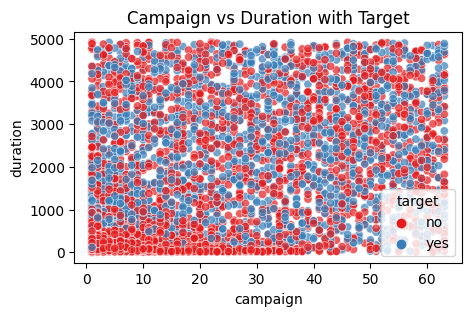

In [19]:
# Duration vs campaign interaction
plt.figure(figsize=(5, 3))
sns.scatterplot(data=train, x='campaign', y='duration', hue='target', palette='Set1', alpha=0.7)
plt.title('Campaign vs Duration with Target')
plt.show()

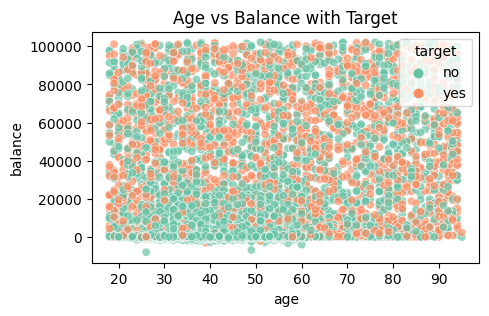

In [20]:
# Age vs balance interaction
plt.figure(figsize=(5, 3))
sns.scatterplot(data=train, x='age', y='balance', hue='target', palette='Set2', alpha=0.7)
plt.title('Age vs Balance with Target')
plt.show()

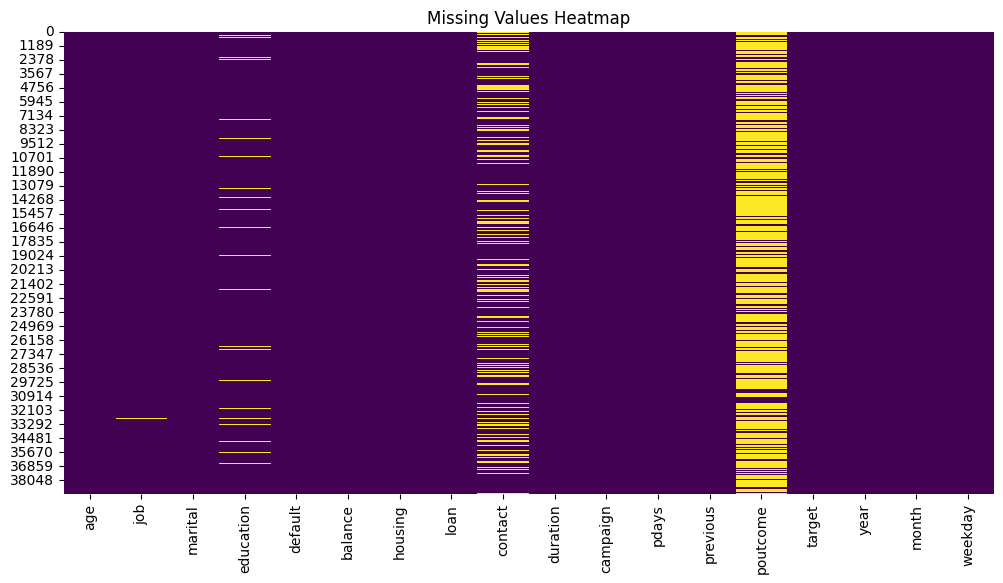

In [21]:
# Missing value visualization
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [22]:
# Define feature engineering function
def create_features(df):
    # Create copy to avoid modifying original data
    df = df.copy()
    
    # Create age groups
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 20, 30, 40, 50, 60, 100],
                            labels=['0-20', '21-30', '31-40', '41-50', '51-60', '60+'])
    
    # Create balance groups
    df['balance_group'] = pd.qcut(df['balance'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    
    # Create campaign intensity feature (handle division by zero)
    df['campaign_intensity'] = df['campaign'] / (df['pdays'].replace(-1, 999) + 1)
    df['campaign_intensity'] = df['campaign_intensity'].clip(upper=df['campaign_intensity'].quantile(0.99))
    
    # Create contact rate (handle division by zero)
    df['contact_rate'] = df['previous'] / (df['pdays'].replace(-1, 999) + 1)
    df['contact_rate'] = df['contact_rate'].clip(upper=df['contact_rate'].quantile(0.99))
    
    # Create interaction features
    df['age_balance'] = df['age'] * df['balance']
    df['age_balance'] = df['age_balance'].clip(upper=df['age_balance'].quantile(0.99))
    
    df['duration_campaign'] = df['duration'] * df['campaign']
    df['duration_campaign'] = df['duration_campaign'].clip(upper=df['duration_campaign'].quantile(0.99))
    
    # Replace any remaining infinities with NaN (will be handled by imputer)
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df


# Apply feature engineering
train = create_features(train)

In [23]:
# Split features and target
X = train.drop(columns=['target', 'year'])
y = (train['target'] == 'yes').astype(int)                                             

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define column groups
num = ['age', 'previous', 'pdays', 'duration', 'balance', 
       'campaign_intensity', 'contact_rate', 'age_balance', 'duration_campaign']
ordinal_cat = ['education']
nominal_cat = ['marital', 'housing', 'loan', 'default', 'weekday', 'contact', 
               'job', 'poutcome', 'age_group', 'balance_group']


In [24]:
# Create pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=[['primary', 'secondary', 'tertiary']]))
])

nominal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [25]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', num_pipe, num),
        ('ordinal', ordinal_pipe, ordinal_cat),
        ('nominal', nominal_pipe, nominal_cat)
    ],
    remainder='passthrough'
)                 

# Fit preprocessor and transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [26]:
# Model: Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=8, class_weight='balanced')
rf_model.fit(X_train_transformed, y_train)
rf_preds = rf_model.predict(X_test_transformed)
f1_rf = f1_score(y_test, rf_preds, average='macro')
print(f"Random Forest F1 Score: {f1_rf:.4f}")

# Model: LightGBM
lgbm_model = LGBMClassifier(random_state=42, n_estimators=250, max_depth=4, class_weight='balanced', learning_rate=0.07)
lgbm_model.fit(X_train_transformed, y_train)
lgbm_preds = lgbm_model.predict(X_test_transformed)
f1_lgbm = f1_score(y_test, lgbm_preds, average='macro')
print(f"LightGBM F1 Score: {f1_lgbm:.4f}")

# Model: XGBoost
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=3,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    subsample=0.70,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.15,
    reg_lambda=1.2,
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=15
)
xgb_model.fit(X_train_transformed, y_train, eval_set=[(X_test_transformed, y_test)], verbose=True)
xgb_preds = xgb_model.predict(X_test_transformed)
f1_xgb = f1_score(y_test, xgb_preds, average='macro')
print(f"XGBoost F1 Score: {f1_xgb:.4f}")


# Train with evaluation set
xgb_model.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_test_transformed, y_test)],
    verbose=True
)

# Compare models
print("\nModel Performance:")
print(f"Random Forest: {f1_rf:.4f}")
print(f"LightGBM: {f1_lgbm:.4f}")
print(f"XGBoost: {f1_xgb:.4f}")

Random Forest F1 Score: 0.7404
[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [27]:

# Use the best model for final predictions
best_model = max([(rf_model, f1_rf), (lgbm_model, f1_lgbm), (xgb_model, f1_xgb)], key=lambda x: x[1])[0]

# Print results

In [28]:

print("\nTraining Set Results:")
y_pred_train = best_model.predict(X_train_transformed)
print(classification_report(y_train, y_pred_train))

print("\nTest Set Results:")
y_pred_test = best_model.predict(X_test_transformed)
print(classification_report(y_test, y_pred_test))


Training Set Results:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     26707
           1       0.54      0.84      0.66      4661

    accuracy                           0.87     31368
   macro avg       0.75      0.86      0.79     31368
weighted avg       0.91      0.87      0.88     31368


Test Set Results:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6677
           1       0.51      0.80      0.63      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.83      0.77      7843
weighted avg       0.89      0.86      0.87      7843



In [29]:
# Process test data similarly to training data
test['last contact date'] = pd.to_datetime(test['last contact date'])
test['year'] = test['last contact date'].dt.year
test['month'] = test['last contact date'].dt.month
test['weekday'] = test['last contact date'].dt.weekday
test.drop(columns=['last contact date'], inplace=True)

# Apply feature engineering to test data
test = create_features(test)

# Drop year column to match training data
test = test.drop(columns=['year'])

# Transform test data using fitted preprocessor
test_transformed = preprocessor.transform(test)


In [30]:
# Make predictions on test data
test_predictions = best_model.predict(test_transformed)
test_probabilities = best_model.predict_proba(test_transformed)

# Create submission dataframe
submission = pd.DataFrame({
    'id': test.index,
    'target': ['yes' if pred == 1 else 'no' for pred in test_predictions]
})

print("\nFirst few predictions:")


# Save predictions to CSV
submission.to_csv('submission.csv', index=False)
submission



First few predictions:


,id,target
0,0,no
1,1,no
2,2,no
3,3,no
4,4,yes
...,...,...
9995,9995,no
9996,9996,yes
9997,9997,yes
9998,9998,no


dummy classifier here

In [31]:
#df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
#X = df.drop("target", axis=1)
#y = df['target']

#from sklearn.dummy import DummyClassifier
#model = DummyClassifier().fit(X,y)

#X_test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
#y_pred=model.predict(X_test)

#submission = pd.DataFrame({"id": range(0,X_test.shape[0]), 
 #                          "target": y_pred}) 

#submission.to_csv('submission.csv',index=False)
#output = pd.read_csv("submission.csv")
#output